<a href="https://colab.research.google.com/github/invisilico/Tutorial-Notebooks/blob/main/Notebook_With_Outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 


# to disable warnings (comment to enable warnings)
import warnings
warnings.filterwarnings("ignore")

from google.colab import files
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import monthrange
from calendar import isleap
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

!curl https://raw.githubusercontent.com/invisilico/DigitalRhythmsProject/master/Sample%20Datasets/nov3data.tar.gz --output MyActivity.tar.gz
!tar -xvf  'MyActivity.tar.gz'

os.rename(r'My Activity.html',r'actdata.txt')
with open('actdata.txt','r') as file:
  txt = file.readlines()
!rm *.* #removes file, bash shell command

actdat = txt[32]

#find indices between which appname and timestamp exists
preapp = [app.end(0) for app in re.finditer('<p class="mdl-typography--title">', actdat)] 
postapp = [app.start(0) for app in re.finditer('<br></p></div><div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1">', actdat)]
posttime = [time.start(0) for time in re.finditer('</div><div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1 mdl-typography--text-right">', actdat)]

appname = []
datetime = []
timezone = []

dd = []
mm = []
yy = []
of24h = []
weekday = []

for i in range(len(posttime)):

  appname += [actdat[preapp[i]:postapp[i]]]
  
  # some (stupid) fix that somehow works but I don't remember why
  stamp = actdat[posttime[i]-30:posttime[i]]
  idx = [app.end(0) for app in re.finditer('>', stamp)]
  if len(idx) > 0:
    stamp = stamp[idx[-1]:]

  datetime += [parse(stamp[:-4])]
  dd += [int(datetime[-1].day)]
  mm += [int(datetime[-1].month)]
  yy += [int(datetime[-1].year)]  
  of24h +=   [np.round(int(datetime[-1].hour)+(int(datetime[-1].minute)/60), decimals = 3)]
  timezone += [stamp[-3:]]
  weekday += [int(datetime[-1].weekday())]

appname.reverse()
of24h.reverse()
dd.reverse()
mm.reverse()
yy.reverse()
timezone.reverse()
datetime.reverse()

data = pd.DataFrame(list(zip(appname,of24h,dd,mm,yy,timezone,weekday,datetime)),columns = ['App','of24h','Day','Month','Year','TimeZone','Weekday','TimeStamp'])

print("\n\n\nbuilt dataframe called data\n~~~ all done! ~~~")
data

# Welcome to ***your*** Digital-Behaviour project!


---

Made by Nishant Jana with lots of inputs from Dr. May Harrington, Dr. Tany leise, Dr. Horacio de la Iglesia and Dr. Raymond Sanchez     

(inspired by the e-mail timestamps project by the de la Iglesia lab @ University of Washington, Seattle!)

(Visualization section heavily adapted from Dr. Leise's SRBR Chronoschool 2020 class)



---


Find me at:

Twitter: [@In_Visilico](https://twitter.com/In_Visilico) , Github: [@invisilico](https://github.com/invisilico) , E-mail: nishantjana5@gmail.com

Feel free to DM/raise an issue/E-mail for any help, feedback and suggestions!


---






---

# Helpful tips

Click the [![](https://user-images.githubusercontent.com/68754864/97426576-a8c14200-1939-11eb-9197-15c7be91ab96.png)] button on the left to each cell to run them. If they have inputs, be sure to fill them first!

Make sure you have the My Activity.html file from takeout.google.com ready to upload.

As long as possible try going ahead linearly rather than going back and forth across sections. Some of the variable names are shared for convenience and your output may keep changing because of it!
```
The steps to be followed are stylized like this and,

# your tasks following each step are marked with a hash!
```



---





---


# Reading the Data

Should you open the HTML file as text, you'll notice that all the data that makes up those panels in the browser version are actually a single (but very long) line of text. That is of no use to us in any way.

What we need here, is to build a DataFrame. A Dataframe is essentially a large table with columns with all the data we need, organised by entry number very similar to excel sheets, but only as big as required. A really important thing about a (pandas) DataFrame is that it allows you to selectively query it to obtain sections of the data that meet your criteria.

The DataFrame made here follows the structure below:


```
# dataframe structure (exemplar)

   App      of24h   Day Month Year  TimeZone Weekday TimeStamp
0  Appname  10.567  2   5     2020  GMT      1       [datetime.datetime(2020, 5, 2, 15, 35, 10)]
1  Appname  12.263  2   5     2020  GMT      1       [datetime.datetime(2020, 5, 2, 15, 35, 10)]
2  Appname  14.139  2   5     2020  GMT      1       [datetime.datetime(2020, 5, 2, 15, 35, 10)]
3  Appname  15.667  2   5     2020  GMT      1       [datetime.datetime(2020, 5, 2, 15, 35, 10)]
```


In [ ]:
#@title Set-Up!

#@markdown Wait for colab to allocate system resources. Once done, click play on the next cell.

# to disable warnings (comment to enable warnings)
import warnings
warnings.filterwarnings("ignore")

from google.colab import files
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import monthrange
from calendar import isleap
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# to disable warnings (comment to enable warnings)
import warnings
warnings.filterwarnings("ignore")



---



In [ ]:
#@title Load the Data from your File

#@markdown This cell will keep running till you select the file. Click the "Choose Files" tile as it appears to select file to upload from your system. The file will be deleted once data is loaded.
#@markdown 
#@markdown Ensure the file is called *exactly* 'My Activity.html'
file = files.upload()
#rename the file to use as text file, read lines method. avoids beautiful soup
os.rename(r'My Activity.html',r'actdata.txt')
with open('actdata.txt','r') as file:
  txt = file.readlines()
print("Data loaded from file.")
!rm *.* #removes file, bash shell command
print("File deleted from Colab, verify in files on left panel.")

In [ ]:
#@title Build a Dataframe

#@markdown This cell makes a dataframe from your data from the file. Might take a while!
actdat = txt[32]

#find indices between which appname and timestamp exists
preapp = [app.end(0) for app in re.finditer('<p class="mdl-typography--title">', actdat)] 
postapp = [app.start(0) for app in re.finditer('<br></p></div><div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1">', actdat)]
posttime = [time.start(0) for time in re.finditer('</div><div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1 mdl-typography--text-right">', actdat)]

appname = []
datetime = []
timezone = []

dd = []
mm = []
yy = []
of24h = []
weekday = []

for i in range(len(posttime)):

  appname += [actdat[preapp[i]:postapp[i]]]
  
  # some (stupid) fix that somehow works but I don't remember why
  stamp = actdat[posttime[i]-30:posttime[i]]
  idx = [app.end(0) for app in re.finditer('>', stamp)]
  if len(idx) > 0:
    stamp = stamp[idx[-1]:]

  datetime += [parse(stamp[:-4])]
  dd += [int(datetime[-1].day)]
  mm += [int(datetime[-1].month)]
  yy += [int(datetime[-1].year)]  
  of24h +=   [np.round(int(datetime[-1].hour)+(int(datetime[-1].minute)/60), decimals = 3)]
  timezone += [stamp[-3:]]
  weekday += [int(datetime[-1].weekday())]

appname.reverse()
of24h.reverse()
dd.reverse()
mm.reverse()
yy.reverse()
timezone.reverse()
datetime.reverse()

data = pd.DataFrame(list(zip(appname,of24h,dd,mm,yy,timezone,weekday,datetime)),columns = ['App','of24h','Day','Month','Year','TimeZone','Weekday','TimeStamp'])

data

,App,of24h,Day,Month,Year,TimeZone,Weekday,TimeStamp
0,Google,11.983,16,1,2020,IST,0,2020-01-16 11:59:15
1,Google Chrome: Fast &amp; Secure,12.567,16,1,2020,IST,0,2020-01-16 12:34:47
2,Gmail,12.567,16,1,2020,IST,0,2020-01-16 12:34:55
3,WhatsApp Messenger,12.900,16,1,2020,IST,0,2020-01-16 12:54:11
4,com.motorola.launcher3,13.317,16,1,2020,IST,0,2020-01-16 13:19:17
...,...,...,...,...,...,...,...,...
51120,Google,13.283,15,11,2021,IST,3,2021-11-15 13:17:30
51121,com.oppo.launcher,13.283,15,11,2021,IST,3,2021-11-15 13:17:55
51122,com.coloros.safecenter,14.000,15,11,2021,IST,3,2021-11-15 14:00:56
51123,Gmail,14.000,15,11,2021,IST,3,2021-11-15 14:00:57


```
# Can you think of a better way to store the data? Do you see any issues with the current dataframe structure?
```


---





---


# What data do we have here?

Running the cell below produces a raster plot for a single month of your choice. A raster plot is used widely for neural spiking data or any sort of repetitive binary data across time. A tick represents an event and blank space shows absence of event. Accordingly, it also means that two events cannot simultaneously occur. (two apps can be opened in succession, but not at the same time). It is also called an event plot in the python matplotlib pyplot library.


```
Look at the plot below for any month of your choosing, and see what your data looks like.

Note that each vertical stripe (a tick) is the event of an app being opened.
```
---



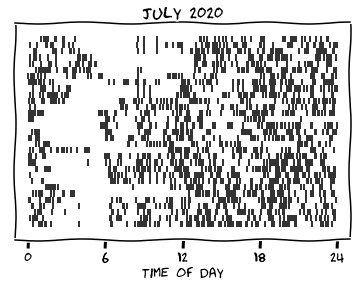

In [ ]:
#@title Month Raster Plotter

Year =  2020 #@param {type:"number"}
Month = "July" #@param ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]


with_XKCD = True #@param {type:"boolean"}
 #@markdown I love the xkcd comics and their style being applied to my plots, but your professor may not. If you have to submit the output, I suggest you untick xkcd before doing so.

monthnames  = {"January":1, "February":2, "March":3, "April":4, "May":5, "June":6, "July":7, "August":8, "September":9 ,"October":10, "November":11, "December":12}

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

def mmraster(dataframe,year,month,xkcd):
  
  mnum = monthnames[Month]
  plotdata = mmprepdata(dataframe,year,mnum)

  if xkcd == True:

    with plt.xkcd():
      plt.eventplot(plotdata[:], color = "0.2")
      plt.xlabel("Time of Day")
      plt.title((str(month)+" "+str(year)))
      plt.xlim(-1,25)
      plt.yticks([])
      plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))
    
  else:

    plt.eventplot(plotdata[:], color = "0.2")
    plt.xlabel("Time of Day")
    plt.title((str(month)+" "+str(year)))
    plt.xlim(-1,25)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))

mmraster(data,Year,Month,with_XKCD)

```
#what do you see? Are there any any noticable patterns?
```


---





---


# Cleaning Data (and issues with data collection)
Okay first things first, Now that you've seen your data there are some background checks to be done. Take a good hard look at the plot(s).


```
> Are the ticks at the correct time?
> Is it sparse or too dense? 
> Is there data on the plot at all? 
> Is it only restricted to the left-half (first 12 hours of the plot)?
```


These issues shouldn't be there, and are generated by the way we source or read the data. No activity means your records don't exist (or my code did not work as intended). Sparse activity might be from low usage on your end or, your phone only partially logging data. Chunks of missing data when you know your phone was on could be caused by logging issues as well. These are all part of the data collection process, and generally, unless you can repeat the experiment, you just have to deal with the hand you're dealt. 


Dr. Leise faced a similar issue with data from [polar bears](https://journals.sagepub.com/doi/abs/10.1177/0748730419900877?journalCode=jbra), 
and of course you can't go and ask a polar bear to fill in some of the missing data.  
So she used innovative mathematical ways I barely understand to make cool inferences from the data nonetheless. 
[Read more here!](https://doi.org/10.1177/0748730417709105)

Some errors may also be caused directly by the way you read the data and can be fixed. 
If all your data is in the first 12 hours in the 24 hour day, or exists and shows a blank plot, 
I messed up big time, and you should let me know!

```
Let's just hope these issues did not occur with your data. 
```

---


There's one thing though. In this particular case, we want to look at *your* usage of the phone and yours alone. From the data I've seen so far, most phones only record events from when *you* opened an app. But some phones have these pesky little events marked at times when their users were asleep or busy.
```
So look again, at times of the day you're sure you were asleep or definitely not using your phone. 

If you see pesky ticks there:
>   Clean your data using the cells below!

If not:
>   Woohoo, skip ahead to Visualization!
```
Whichever path you take, take a minute to realise that this cleaning of the data will change your outcomes. For us, as we are interested in seeing *your* activity, this is noise, but to someone studying phone activity as a whole, this is vital information! 

What counts as noise and error is often determined by your question, and any such decisions that you make should be properly reported when you publish/share your work!


---





---

# Visualization!


Obtaining and cleaning data is only the beginning. The real fun starts with making sense of the data. 

However, reading each entry does us no good. Here comes the power of visualization!

> Note: If your plots are too small and blurry, scroll down to the end and there's a figure resolution controller cell.

```
Run the following cells to generate a few visuals from your data. 

Each visual tells a different story and aims to communicate a different facet of your data.

# See what they have to say about you! Note it down!
```

This is by no means an exhaustive list of possible visualisation but only a few commonly used ones that seem to work with this sort of data. 

If you're feeling adventurous, try some other ones you know of! Share them with me so I can add them here too!


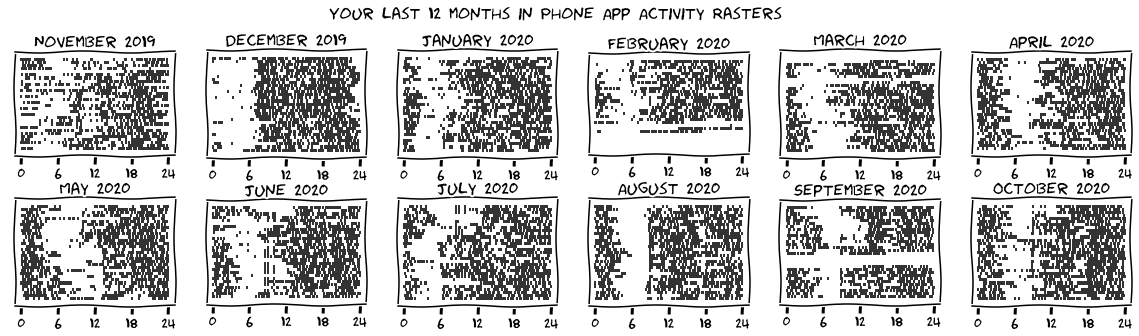

In [ ]:
#@title Of course, you could just start by generating raster plots for each of the last 12 months. Run this to see *your* year so far!
#@markdown The month previous to the latest is considered to make sure we only look at complete months

xkcd = True #@param {type:"boolean"}

#functions

def last_12_months(dataframe):

  last_month = data['Month'].iloc[-1] - 1
  last_year = data['Year'].iloc[-1]
  mnamelst = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

  mlist = []
  mnlist = []
  ylist = []

  for i in range(12):
    # months
    if last_month - i > 0:
      mlist += [last_month - i]
    else:
      mlist += [last_month - i + 12]
    # year
    if last_month - i <= 0:
      ylist += [last_year-1]
    else:
      ylist += [last_year]
    # month names
    mnlist += [mnamelst[last_month - i - 1]]

  mlist.reverse()
  mnlist.reverse()
  ylist.reverse()

  return mlist,mnlist,ylist

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

def twelvemonthrast(dataframe, mlist, ylist, mnlist, xkcd):
  
  prepped_data = []

  for i in range(len(mlist)):
    prepped_data += [mmprepdata(dataframe, ylist[i], mlist[i])]

  return prepped_data

#actual calls

mlist,mnlist,ylist = last_12_months(data)

dataforraster = twelvemonthrast(data,mlist,ylist,mnlist,xkcd)

if xkcd == True:
  with plt.xkcd():
    yrrast, plots = plt.subplots(2, 6)
    yrrast.suptitle(('Your last 12 months in Phone App Activity Rasters'))
    plt.gcf().set_size_inches(20,5)
    for i in range(2):
      for j in range(6):
        plots[i,j].eventplot(dataforraster[(i*6)+j], color = '0.2')
        plots[i,j].set_title(( (str(mnlist[(i*6)+j]))+" "+str(ylist[(i*6)+j]) ))
        plots[i,j].set_xlim(-1,25)
        plots[i,j].set_yticks([])
        plots[i,j].xaxis.set_major_locator(ticker.MultipleLocator(6))
        plots[i,j].set_aspect(0.5)
else:

    yrrast, plots = plt.subplots(2, 6)
    yrrast.suptitle(('Your last 12 months in Phone App Activity Rasters'))
    plt.gcf().set_size_inches(20,5)
    for i in range(2):
      for j in range(6):
        plots[i,j].eventplot(dataforraster[(i*6)+j], color = '0.2')
        plots[i,j].set_title(( (str(mnlist[(i*6)+j]))+" "+str(ylist[(i*6)+j]) ))
        plots[i,j].set_xlim(-1,25)
        plots[i,j].set_yticks([])
        plots[i,j].xaxis.set_major_locator(ticker.MultipleLocator(6))
        plots[i,j].set_aspect(0.5)



```
There's lots to see here for the trained eye! 
# Do you see any patterns? 
# Months where you were more regular? (Onset of Activity was around the same time?)
# Months when offset of activity was regular?
# Are you rhythmic or arrhythmic?
# Do you see times when you got a little delayed or earlier each day? (You may have been freerunning!)
# Are there changes across seasons/academic schedules?
```
rasters are a great way of seeing the entirety of the data, but it is often hard to note everything from it. 




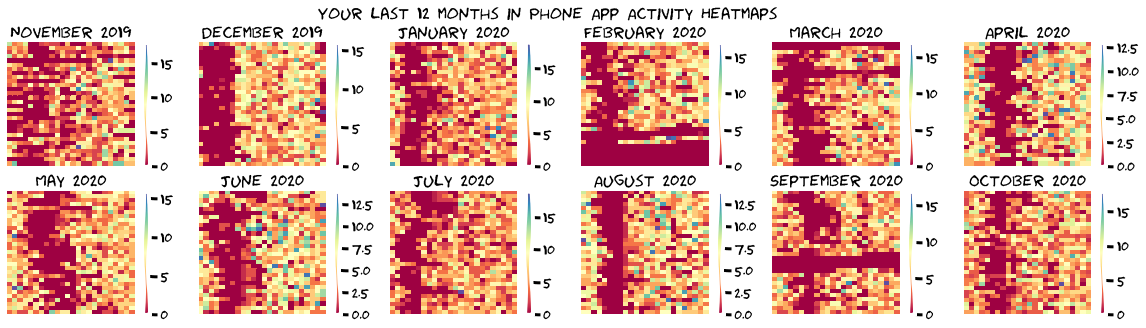

In [ ]:
#@title Heatmaps!

xkcd = True #@param {type:"boolean"}

#functions (same as previous)

def last_12_months(dataframe):

  last_month = data['Month'].iloc[-1] - 1
  last_year = data['Year'].iloc[-1]
  mnamelst = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

  mlist = []
  mnlist = []
  ylist = []

  for i in range(12):
    # months
    if last_month - i > 0:
      mlist += [last_month - i]
    else:
      mlist += [last_month - i + 12]
    # year
    if last_month - i <= 0:
      ylist += [last_year-1]
    else:
      ylist += [last_year]
    # month names
    mnlist += [mnamelst[last_month - i - 1]]

  mlist.reverse()
  mnlist.reverse()
  ylist.reverse()

  return mlist,mnlist,ylist

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

def twelvemonthrasterprep(dataframe, mlist, ylist, mnlist, xkcd):
  
  prepped_data = []

  for i in range(len(mlist)):
    prepped_data += [mmprepdata(dataframe, ylist[i], mlist[i])]

  return prepped_data

#functions (new)

def heatmapconversion(dataforraster):

  dataforheatmap = []

  for month in dataforraster:
    heatformonth = np.empty((month.shape[0],24))
    for i in range(month.shape[0]):
      for j in range(24):
        heatformonth[-i-1,j] = np.sum(month[i]<j+1)-np.sum(month[i]<j)
    dataforheatmap += [heatformonth]

  return dataforheatmap

#function calls

mlist,mnlist,ylist = last_12_months(data)

dataforheatmap = heatmapconversion(twelvemonthrasterprep(data,mlist,ylist,mnlist,xkcd))

if xkcd == True:
  with plt.xkcd():
    yrrast, plots = plt.subplots(2, 6)
    yrrast.suptitle(('Your last 12 months in Phone App Activity Heatmaps'))
    plt.gcf().set_size_inches(20,5)
    for i in range(2):
      for j in range(6):
         sns.heatmap(dataforheatmap[(i*6)+j],cmap="Spectral",xticklabels=False,yticklabels=False,ax=plots[i,j])
         plots[i,j].set_title(( (str(mnlist[(i*6)+j]))+" "+str(ylist[(i*6)+j]) ))

else:
    yrrast, plots = plt.subplots(2, 6)
    yrrast.suptitle(('Your last 12 months in Phone App Activity Heatmaps'))
    plt.gcf().set_size_inches(20,5)
    for i in range(2):
      for j in range(6):
         sns.heatmap(dataforheatmap[(i*6)+j],cmap="Spectral",xticklabels=False,yticklabels=False,ax=plots[i,j])
         plots[i,j].set_title(( (str(mnlist[(i*6)+j]))+" "+str(ylist[(i*6)+j]) ))

```
Heatmaps are great at showing changes in activity level over time.
They are not as specific in their representation, for example, this plot is binned hour wise.

# What do you see in this plot that is more clear than in rasters?
# What aspect of the rasters were lost in these plots?
```

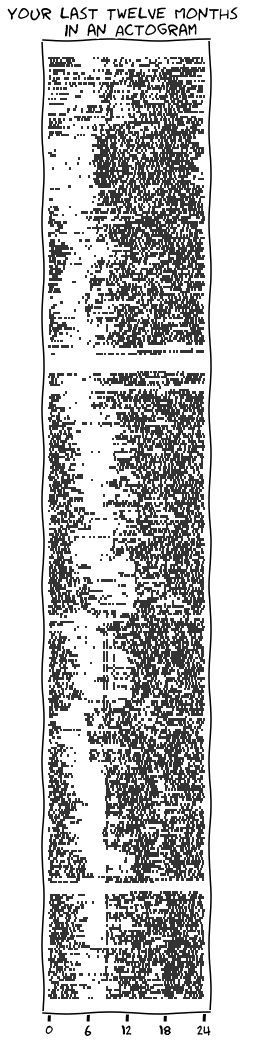

In [ ]:
#@title Single-Plotted Actogram

xkcd = True #@param {type:"boolean"}

#functions

def last_12_months(dataframe):

  last_month = data['Month'].iloc[-1] - 1
  last_year = data['Year'].iloc[-1]
  mnamelst = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

  mlist = []
  mnlist = []
  ylist = []

  for i in range(12):
    # months
    if last_month - i > 0:
      mlist += [last_month - i]
    else:
      mlist += [last_month - i + 12]
    # year
    if last_month - i <= 0:
      ylist += [last_year-1]
    else:
      ylist += [last_year]
    # month names
    mnlist += [mnamelst[last_month - i - 1]]

  mlist.reverse()
  mnlist.reverse()
  ylist.reverse()

  return mlist,mnlist,ylist

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

def twelvemonthrast(dataframe, mlist, ylist, mnlist, xkcd):
  
  prepped_data = []

  for i in range(len(mlist)):
    prepped_data += [mmprepdata(dataframe, ylist[i], mlist[i])]

  return prepped_data

#actual calls

mlist,mnlist,ylist = last_12_months(data)

dataforraster = twelvemonthrast(data,mlist,ylist,mnlist,xkcd)

# new code
longplot = np.empty((0,),dtype = object)

for month in dataforraster:
  longplot = np.append(month,longplot)

if xkcd == True:

  with plt.xkcd():
    plt.title(('Your last Twelve Months \n in an Actogram'))
    plt.gcf().set_size_inches(3,20)
    plt.eventplot(longplot, color = '0.2')
    plt.xlim(-1,25)
    plt.ylim(-6,372)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))
    plt.gca().set_aspect(0.4)

else:

    plt.title(('Your last Twelve Months \n in an Actogram'))
    plt.gcf().set_size_inches(3,20)
    plt.eventplot(longplot, color = '0.2')
    plt.xlim(-1,25)
    plt.ylim(-6,372)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))
    plt.gca().set_aspect(0.2)

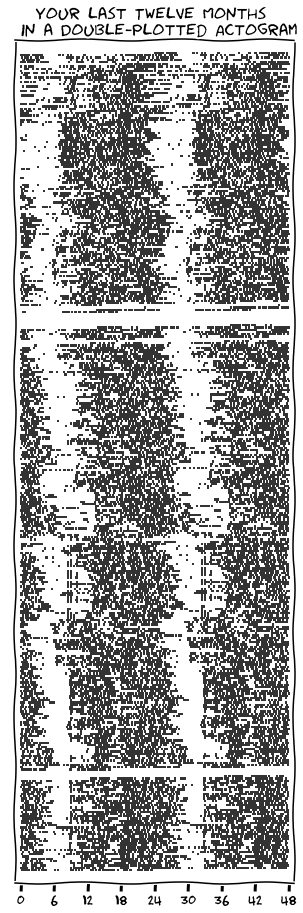

In [ ]:
#@title Double-Plotted Actogram

xkcd = True #@param {type:"boolean"}

#functions

def last_12_months(dataframe):

  last_month = data['Month'].iloc[-1] - 1
  last_year = data['Year'].iloc[-1]
  mnamelst = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

  mlist = []
  mnlist = []
  ylist = []

  for i in range(12):
    # months
    if last_month - i > 0:
      mlist += [last_month - i]
    else:
      mlist += [last_month - i + 12]
    # year
    if last_month - i <= 0:
      ylist += [last_year-1]
    else:
      ylist += [last_year]
    # month names
    mnlist += [mnamelst[last_month - i - 1]]

  mlist.reverse()
  mnlist.reverse()
  ylist.reverse()

  return mlist,mnlist,ylist

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

def twelvemonthrast(dataframe, mlist, ylist, mnlist, xkcd):
  
  prepped_data = []

  for i in range(len(mlist)):
    prepped_data += [mmprepdata(dataframe, ylist[i], mlist[i])]

  return prepped_data

#actual calls

mlist,mnlist,ylist = last_12_months(data)

dataforraster = twelvemonthrast(data,mlist,ylist,mnlist,xkcd)

# new code
longplot = np.empty((0,),dtype = object)

for month in dataforraster:
  longplot = np.append(month,longplot)


#second set being made

doubleplot1 = longplot
doubleplot2 = longplot + 24
ext = np.array([],dtype="float64")
doubleplot2 = doubleplot2.tolist()
doubleplot2.insert(0,ext)
doubleplot2 = np.array(doubleplot2,dtype='object')

#plotting

if xkcd == True:

  with plt.xkcd():
    plt.title(('Your last Twelve Months \n in a Double-Plotted Actogram'))
    plt.gcf().set_size_inches(5,20)
    plt.xlim(-1,49)
    plt.ylim(-6,372)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))
    plt.gca().set_aspect(0.4)
    plt.eventplot(doubleplot1, color = '0.2')
    plt.eventplot(doubleplot2, color = '0.2')

else:

    plt.title(('Your last Twelve Months \n in a Double-Plotted Actogram'))
    plt.gcf().set_size_inches(5,20)
    plt.xlim(-1,49)
    plt.ylim(-6,372)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(6))
    plt.gca().set_aspect(0.4)
    plt.eventplot(doubleplot1, color = '0.2')
    plt.eventplot(doubleplot2, color = '0.2')

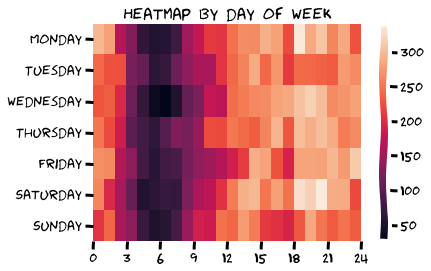

In [ ]:
#@title Heatmap by day of week!
dayslist = ["Monday", "Tuesday", "wednesday","Thursday","Friday","Saturday","Sunday"]
nos_of_weeks = 52 #@param {type: "number"}
#@markdown Note: Data beyond 78 weeks (1.5 years) is usually unreliable.
binning = "60 mins" #@param ["60 mins", "30 mins", "15 mins", "5 mins"]

bin_type = {"60 mins":24, "30 mins":48, "15 mins":96, "5 mins":288}

bins = bin_type[binning]


#@markdown This allows you to control the binning of the data
xkcd = True #@param {type:"boolean"}
nosofdays = nos_of_weeks*7
# get the date n weeks ago
datenwksago = data["TimeStamp"].iloc[-1] - timedelta(days=nosofdays)
# query dataframe to section from that date onwards
frame = data.query(("TimeStamp > @datenwksago"))
# sort by weekday and add up all the data together into one array

def prepdatafordayofweekheatmap(nwksagoframe,bins):
  # dict to store data
  data = {}
  # for each day of the week
  for i in range(7):
    # get the time data for the day of the week
    onedayofweek = nwksagoframe.query(("Weekday == @i"))
    timedata = onedayofweek["of24h"].to_numpy()
    # prepare array to store data
    dataforday = np.empty((bins))
    # size of increment relative to binning
    divinc = 24/bins
    # count how many fall in that bin
    for j in range(bins):
      dataforday[j] = np.sum(timedata < j*divinc + divinc) - np.sum(timedata < j*divinc)
    # collect data in dictionary
    data[dayslist[i]] = dataforday
  return data

dataformap = pd.DataFrame.from_dict(prepdatafordayofweekheatmap(frame,bins))

# plot this as heatmaps 
if xkcd == True:
  with plt.xkcd():
    sns.heatmap(dataformap.T)
    plt.title("Heatmap by day of week")
    if bins == 24:
      plt.xticks([0,3,6,9,12,15,18,21,24],[0,3,6,9,12,15,18,21,24])
    if bins == 48:
      plt.xticks([0,6,12,18,24,30,36,42,48],[0,3,6,9,12,15,18,21,24])
    if bins == 96:
      plt.xticks([0, 12, 24, 36, 48, 60, 72, 84, 96],[0,3,6,9,12,15,18,21,24])
    if bins == 288:
      plt.xticks([0, 36, 72, 108, 144, 180, 216, 252, 288],[0,3,6,9,12,15,18,21,24])

else:
    sns.heatmap(dataformap.T)
    plt.gca().invert_yaxis()
    plt.title("Heatmap by day of week")
    if bins == 24:
      plt.xticks([0,3,6,9,12,15,18,21,24],[0,3,6,9,12,15,18,21,24])
    if bins == 48:
      plt.xticks([0,6,12,18,24,30,36,42,48],[0,3,6,9,12,15,18,21,24])
    if bins == 96:
      plt.xticks([0, 12, 24, 36, 48, 60, 72, 84, 96],[0,3,6,9,12,15,18,21,24])
    if bins == 288:
      plt.xticks([0, 36, 72, 108, 144, 180, 216, 252, 288],[0,3,6,9,12,15,18,21,24])

```
# what did you see in these plots?
# When averaged across days, was there a trend emerging? 
# Are there certain hours you're always away from your phone?
# Do you think it might be a good proxy for your sleep time?
```


---





---

# Estimating periodicity!

Using Auto-Correlation!

This method broadly works with discritized timeseries data, best so when the readings do not change level but are binary.

```
 # In a given time bin
 1 = Activity
 0 = Inactivity
```

The rough idea is to shift the data by discrete timesteps to observe the correlation of the data to itself, with the highest relative value appearing when the data is the most strongly over-lapping with itself. In our case we should see it happen at the average "period" of activity: roughly 24 hours, confirming that we are indeed circadian in our digital behaviour!



The first peak of autocorrelation is at : 24.0



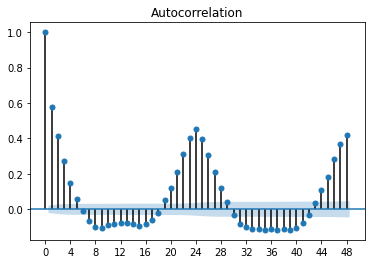

In [ ]:
#@title Use AutoCorrelation to estimate the periodicity of your data
#@markdown Note: only data from the last 52 weeks is used!
binning = "60 mins" #@param ["60 mins", "30 mins", "15 mins", "5 mins"]

bin_type = {"60 mins":24, "30 mins":48, "15 mins":96, "5 mins":288}

bins = bin_type[binning]


#@markdown This allows you to control the binning of the data
xkcd = False #@param {type:"boolean"}

#functions (same as previous)

def last_12_months(dataframe):

  last_month = data['Month'].iloc[-1] - 1
  last_year = data['Year'].iloc[-1]
  mnamelst = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

  mlist = []
  mnlist = []
  ylist = []

  for i in range(12):
    # months
    if last_month - i > 0:
      mlist += [last_month - i]
    else:
      mlist += [last_month - i + 12]
    # year
    if last_month - i <= 0:
      ylist += [last_year-1]
    else:
      ylist += [last_year]
    # month names
    mnlist += [mnamelst[last_month - i - 1]]

  mlist.reverse()
  mnlist.reverse()
  ylist.reverse()

  return mlist,mnlist,ylist

def mmprepdata(dataframe, ynum, mnum):
  
    frame = dataframe.query(('Year == '+str(ynum)+' and Month == '+str(mnum)))
    
    days = monthrange(ynum,mnum)[1]
    plotdata = np.empty(days, dtype = object)
    for d in range(days):
      daydata = frame.query(('Day == '+str(d+1)))
      plotdata[-d-1] = daydata.of24h.to_numpy()

    return plotdata

def twelvemonthrasterprep(dataframe, mlist, ylist, mnlist):
  
  prepped_data = []

  for i in range(len(mlist)):
    prepped_data += [mmprepdata(dataframe, ylist[i], mlist[i])]

  return prepped_data

#functions (new)

def heatmapconversion(dataforraster,bins):

  dataforheatmap = []
  divinc = 24/bins
  for month in dataforraster:
    heatformonth = np.empty((month.shape[0],bins),dtype = "object")
    for i in range(month.shape[0]):
      for j in range(bins):
        heatformonth[-i-1,j] = np.sum(month[i]<j*divinc+divinc)-np.sum(month[i]<j*divinc)
    dataforheatmap += [heatformonth]

  return dataforheatmap

#function calls

mlist,mnlist,ylist = last_12_months(data)

dataforheatmap = heatmapconversion(twelvemonthrasterprep(data,mlist,ylist,mnlist), bins)

# collect the data from output for heatmaps (24hour version, !!! update to 48 hour version later!!! )

discretized_data = []
discrete_data_permonth = []

for month in dataforheatmap:
  datan = []
  for i in range(month.shape[0]):
    datan += month[i].tolist()
  discrete_data_permonth += [datan]
  discretized_data += datan

# convert to binary data
arr_discrete = np.array(discretized_data)
bin_discrete = arr_discrete > 0

# calculate periodicity
autocorr = sm.tsa.acf(bin_discrete, nlags = bins*2)
small_seg = autocorr[int(bins/2):int(bins+bins/2)]
peak = (small_seg.argsort()[-1]+bins/2) / (bins/24)
print("The first peak of autocorrelation is at : "+str(peak)+"\n")

# plot autocorr
if xkcd:
  with plt.xkcd():
    plot_acf(bin_discrete, lags = bins*2)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))
else:
    plot_acf(bin_discrete, lags = bins*2)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))



---

# End of the line!

Take a print! Download your results!




In [ ]:
#@title figure resolution controller

plot_dpi = 120 #@param {type:"integer"}
#@markdown Set the above value to control how big the plots are. It will vary for each screen

#@markdown Setting it to higher values may make plots very large on screen but are ideal for downloading it and using it elsewhere. A minimum of 300dpi is ideal for print, I prefer 600dpi.
mpl.rcParams['figure.dpi'] = plot_dpi



---

# Please consider sharing your data with us! 



In [ ]:
#@title Privacy Filter ???
#@markdown Removes app names for privacy when sharing data. All apps are renamed to "app" with exception of clock/alarm apps which are renamed to "clock"

dataframe.loc[dataframe['App'].str.contains('clock', case=False), 'App'] = 'clock'
dataframe.loc[dataframe['App'] != "clock", "App"] = "app"

print("appnames have been removed, replaced with "+str(dataframe.App.unique())+"\n\n")
print(dataframe.head())



---

# Clean Slate!





In [ ]:
#@markdown Deletes all files from colab for privacy.
#@markdown
#@markdown (Make sure to only run this **after** you've saved everything you need!)
!rm *.*
print("Done and Dusted!")



---

